So we know that Gumbel selects things relatively well. Its effects of Zeisel though are a bit muddled because of reconstruction. Let's do a simple synethetic dataset. Half the features are real. Half the features at noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [4]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 10
#n_epochs = 20
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999


# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'

In [6]:
print("Device")
print(device)

Device
cuda:0


Create the data

In [7]:
D = 30
N = 5000
z_size = 5

In [8]:
latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

In [9]:
data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=False)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=30, bias=True)
  (3): ReLU()
)

In [10]:
latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [ 0.2501, -1.0168,  0.0459,  0.5006,  1.2243],
        [-0.5595,  1.5234, -0.5857,  0.8466, -0.1063],
        [ 0.7700,  0.7508, -0.5606, -1.7603,  0.4371]], device='cuda:0')

In [11]:
actual_data = data_mapper(latent_data)

In [12]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(19, device='cuda:0')
tensor(12, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(14, device='cuda:0')


For each sample, half the data is non zero, whereas in zeisel, about 25% if non zero. Easier than Zeisel good.

In [13]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[-1.0921e-02, -6.1085e-04, -1.4928e-02,  ..., -1.4309e-02,
          1.6859e-02, -1.2177e-02],
        [ 7.6496e-03,  1.1971e-02, -2.2414e-02,  ...,  1.0256e-02,
         -5.5957e-03,  4.3434e-03],
        [ 2.7566e-03,  1.0969e-03,  3.5942e-03,  ...,  6.0039e-03,
          8.7524e-04,  7.0365e-03],
        ...,
        [ 1.8449e-02,  8.3797e-04, -8.9499e-03,  ...,  8.9735e-04,
         -1.6982e-03,  7.8153e-03],
        [-1.0649e-02, -9.6204e-03, -8.1562e-03,  ..., -2.2612e-04,
         -1.4104e-02, -8.2127e-03],
        [ 2.1183e-02, -1.1416e-02,  1.8769e-03,  ..., -1.3100e-02,
         -6.2333e-03, -4.3646e-05]], device='cuda:0')

In [14]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [15]:
actual_data.shape

torch.Size([5000, 60])

In [16]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

In [17]:
actual_data.std(dim = 0)

tensor([0.1866, 0.2313, 0.2054, 0.2209, 0.2323, 0.1899, 0.1801, 0.1969, 0.1133,
        0.2353, 0.0925, 0.1310, 0.1725, 0.1902, 0.2294, 0.2275, 0.2082, 0.0530,
        0.0980, 0.1738, 0.1728, 0.2156, 0.0460, 0.0932, 0.0255, 0.1816, 0.1587,
        0.2263, 0.2125, 0.2393, 0.1326, 0.1439, 0.1281, 0.1421, 0.1297, 0.1413,
        0.1492, 0.1272, 0.1233, 0.1420, 0.1422, 0.1363, 0.1256, 0.1288, 0.1377,
        0.1438, 0.1337, 0.1331, 0.1258, 0.1346, 0.1507, 0.1223, 0.1429, 0.1343,
        0.1348, 0.1361, 0.1388, 0.1391, 0.1426, 0.1383], device='cuda:0')

Standard deviatiosn are comparable.

In [18]:
actual_data.max(dim = 0)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
indices=tensor([ 738, 4262, 1553, 1484, 2220, 1316, 3892, 1316, 3121, 3883, 1838,  623,
        1004, 4856,  689, 2033, 2038, 1316, 4515, 4562, 4668,  616,  894, 4515,
        1885, 3892, 4615,  819, 4397, 4293,  713, 2220, 3813, 4659, 4389, 3659,
         309, 1804,  495, 4790, 3110, 4671,   36,    0, 1215,  148, 4008, 1317,
        2503, 1402, 1580, 2684, 4078, 3334, 1376, 2499, 1301, 3114, 4203, 3183],
     

In [19]:
actual_data.min(dim = 0)

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
indices=tensor([   1,    8,    0,    1,    0,    5,    1,    1,    1,    0,    1,    1,
           0,   13,    3,    3,    1,    0,    0,    1,    1,    8,    0,    0,
           0,    1,  254,    4,    0,    0,  454, 3677, 1909, 3750, 3638, 4476,
         553, 4105,  289, 1150, 2707, 1846, 3579, 3101,  299, 1324, 3277, 4318,
        3023,  967, 2932, 3588,  919, 1190,  271, 2937, 3428, 3955, 2719,  198],
       device='cuda:0'))

In [20]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(49, device='cuda:0')
tensor(42, device='cuda:0')
tensor(48, device='cuda:0')
tensor(44, device='cuda:0')
tensor(44, device='cuda:0')


In [21]:
slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [22]:
train_data.shape

torch.Size([4000, 60])

In [23]:
test_data.shape

torch.Size([1000, 60])

Look at correlations

In [24]:
def pairwise_correlations(dataset):
    cor_df = np.zeros((dataset.shape[1], dataset.shape[1]))
    for row in np.arange(dataset.shape[1]):
        for col in np.arange(dataset.shape[1]):
            cor_df[row, col] = pearsonr(dataset[row], dataset[col])[0]
    return cor_df

16
2


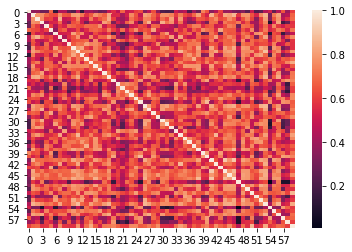

In [25]:
actual_data_clone = actual_data.clone().detach().cpu().numpy()

pairwise_cor_df = pairwise_correlations(actual_data_clone)

import seaborn as sns

sns.heatmap(pairwise_cor_df)

correlates = []
for i in range(2 * D):
    one = np.sum(np.abs(pairwise_cor_df[i, :D]))
    two = np.sum(np.abs(pairwise_cor_df[i, D:2*D]))
    #correlates.append([one, two])
    correlates.append(one > two)
    
# correlation of that feature with the first 30 features and the second 30 features
print(np.sum(correlates[:D]))

print(np.sum(correlates[D:2*D]))

# Now run all of the notebook or just the last part focusing on gumbel vs gradients on truncated (or not) losses

Data is all ready. Now time to feed into into a pretraining-matching Gumbel and joint training Gumbel.

Pre train VAE First

In [24]:
pretrain_vae = VAE(2*D, 100, 20)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

#pretrain_vae_optimizer = torch.optim.SGD(pretrain_vae.parameters(), 
#                                            lr=lr, momentum = 0.9)

In [25]:
for epoch in range(1, n_epochs + 1):
    train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch, batch_size)
    test(test_data, pretrain_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.017113
Train Epoch: 1 [1280/4000 (32%)]	Loss: 40.903053
Train Epoch: 1 [2560/4000 (64%)]	Loss: 39.910145
Train Epoch: 1 [3840/4000 (96%)]	Loss: 39.210461
====> Epoch: 1 Average loss: 40.4244
====> Test set loss: 38.9524
Train Epoch: 2 [0/4000 (0%)]	Loss: 38.888924
Train Epoch: 2 [1280/4000 (32%)]	Loss: 38.212513
Train Epoch: 2 [2560/4000 (64%)]	Loss: 36.419609
Train Epoch: 2 [3840/4000 (96%)]	Loss: 35.664536
====> Epoch: 2 Average loss: 37.3049
====> Test set loss: 35.4656
Train Epoch: 3 [0/4000 (0%)]	Loss: 35.430317
Train Epoch: 3 [1280/4000 (32%)]	Loss: 34.606815
Train Epoch: 3 [2560/4000 (64%)]	Loss: 34.577702
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.209206
====> Epoch: 3 Average loss: 34.6850
====> Test set loss: 34.1042
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.345818
Train Epoch: 4 [1280/4000 (32%)]	Loss: 34.207222
Train Epoch: 4 [2560/4000 (64%)]	Loss: 33.563995
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.908337
====> Epoch: 4 Average loss: 33.88

====> Test set loss: 30.6768
Train Epoch: 33 [0/4000 (0%)]	Loss: 30.802919
Train Epoch: 33 [1280/4000 (32%)]	Loss: 30.749544
Train Epoch: 33 [2560/4000 (64%)]	Loss: 30.829163
Train Epoch: 33 [3840/4000 (96%)]	Loss: 30.446085
====> Epoch: 33 Average loss: 30.6890
====> Test set loss: 30.6682
Train Epoch: 34 [0/4000 (0%)]	Loss: 30.434799
Train Epoch: 34 [1280/4000 (32%)]	Loss: 30.970924
Train Epoch: 34 [2560/4000 (64%)]	Loss: 30.403496
Train Epoch: 34 [3840/4000 (96%)]	Loss: 30.874573
====> Epoch: 34 Average loss: 30.6707
====> Test set loss: 30.6344
Train Epoch: 35 [0/4000 (0%)]	Loss: 30.790586
Train Epoch: 35 [1280/4000 (32%)]	Loss: 30.480667
Train Epoch: 35 [2560/4000 (64%)]	Loss: 30.827261
Train Epoch: 35 [3840/4000 (96%)]	Loss: 30.903517
====> Epoch: 35 Average loss: 30.6488
====> Test set loss: 30.6218
Train Epoch: 36 [0/4000 (0%)]	Loss: 31.043398
Train Epoch: 36 [1280/4000 (32%)]	Loss: 30.573771
Train Epoch: 36 [2560/4000 (64%)]	Loss: 30.547482
Train Epoch: 36 [3840/4000 (96%)]	Lo

In [26]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(pretrain_vae(test_data)[0], test_data))

Test Loss
tensor(0.4964, device='cuda:0')


Actually pretty good! %35 percent off when wrong

Get 0.49 when nepochs is 50.
Get 0.54 when nepochs is 10.

As a note, if the final layer of the data mapper is not ReLU, this reconstruction is usually on point. When some of the features can be sparse, then this becomes troublesome.

Compare means

In [27]:
train_data.mean(dim = 0)[:D]

tensor([0.0931, 0.3051, 0.1384, 0.2096, 0.2092, 0.2112, 0.1042, 0.2325, 0.0347,
        0.2014, 0.0244, 0.0502, 0.0919, 0.2735, 0.2254, 0.3294, 0.2786, 0.0084,
        0.0338, 0.1001, 0.0849, 0.2512, 0.0048, 0.0257, 0.0015, 0.0874, 0.4764,
        0.3270, 0.2107, 0.2899], device='cuda:0')

In [28]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [29]:
pretrain_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1014, 0.3082, 0.1481, 0.2059, 0.2035, 0.2026, 0.1036, 0.2276, 0.0334,
        0.1933, 0.0268, 0.0544, 0.0878, 0.2829, 0.2261, 0.3300, 0.2708, 0.0094,
        0.0353, 0.0994, 0.0870, 0.2518, 0.0070, 0.0294, 0.0036, 0.0922, 0.4750,
        0.3314, 0.2135, 0.2963], device='cuda:0', grad_fn=<SliceBackward>)

Compare standard deviations

In [30]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [31]:
pretrain_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.1635, 0.2089, 0.1991, 0.1973, 0.2046, 0.0988, 0.1592, 0.1667, 0.0784,
        0.2134, 0.0471, 0.0845, 0.1464, 0.1706, 0.2144, 0.2154, 0.1740, 0.0129,
        0.0778, 0.1471, 0.1372, 0.1853, 0.0119, 0.0618, 0.0055, 0.1587, 0.1384,
        0.2182, 0.1869, 0.2146], device='cuda:0', grad_fn=<SliceBackward>)

In [32]:
pretrain_vae(test_data)[0].std(dim = 0)[D:2*D]

tensor([0.0192, 0.0166, 0.0169, 0.0182, 0.0186, 0.0176, 0.0177, 0.0193, 0.0181,
        0.0182, 0.0176, 0.0181, 0.0175, 0.0176, 0.0170, 0.0169, 0.0160, 0.0168,
        0.0176, 0.0168, 0.0176, 0.0161, 0.0185, 0.0188, 0.0188, 0.0182, 0.0179,
        0.0173, 0.0182, 0.0180], device='cuda:0', grad_fn=<SliceBackward>)

In [33]:
average_std = pretrain_vae(test_data)[0].std(dim = 0)[:D] / test_data.std(dim = 0)[:D]

In [34]:
print(average_std)
print(average_std.mean().item())

tensor([0.8577, 0.8759, 0.9402, 0.8815, 0.8857, 0.5150, 0.8801, 0.8438, 0.7950,
        0.9072, 0.5083, 0.6143, 0.8757, 0.8771, 0.9157, 0.9198, 0.8350, 0.3095,
        0.8366, 0.8784, 0.7831, 0.8066, 0.2013, 0.6737, 0.3344, 0.8627, 0.8543,
        0.9643, 0.8786, 0.9155], device='cuda:0', grad_fn=<DivBackward0>)
0.7742371559143066


Get .8 as the mean when nepoch is 50. Get 0.43 as the mean when nepochs is 10.

Compare values

In [35]:
samp = 45

In [36]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [37]:
pretrain_vae(test_data)[0][samp, :D]

tensor([0.0007, 0.4000, 0.0045, 0.1049, 0.6208, 0.3453, 0.0412, 0.3219, 0.0022,
        0.2507, 0.0014, 0.0100, 0.0417, 0.0886, 0.3184, 0.5396, 0.2331, 0.0083,
        0.0024, 0.0026, 0.0709, 0.5700, 0.0041, 0.0025, 0.0013, 0.0598, 0.3389,
        0.0866, 0.5517, 0.3539], device='cuda:0', grad_fn=<SliceBackward>)

In [38]:
torch.abs(test_data[samp,:D] - pretrain_vae(test_data)[0][samp, :D]).mean()

tensor(0.0902, device='cuda:0', grad_fn=<MeanBackward0>)

In [39]:
pretrain_vae(test_data)[1][:, :D].mean()

tensor(-0.0107, device='cuda:0', grad_fn=<MeanBackward0>)

In [40]:
torch.exp(pretrain_vae(test_data)[2][:, :D]).mean()

tensor(0.6380, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
pretrain_vae.requires_grad_(False)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=60, bias=True)
    (3): Sigmoid()
  )
)

This looks pretty good.

**Gumbel matching pretrained VAE next**

In [42]:
# let's see how it does here
vae_gumbel_with_pre = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [43]:
for epoch in range(1, n_epochs + 1):
    train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                      epoch, pretrain_vae, batch_size)
    test(test_data, vae_gumbel_with_pre, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 135.722412
Train Epoch: 1 [1280/4000 (32%)]	Loss: 126.609497
Train Epoch: 1 [2560/4000 (64%)]	Loss: 121.512253
Train Epoch: 1 [3840/4000 (96%)]	Loss: 116.164474
====> Epoch: 1 Average loss: 125.7550
====> Test set loss: 39.4420
Train Epoch: 2 [0/4000 (0%)]	Loss: 118.806061
Train Epoch: 2 [1280/4000 (32%)]	Loss: 115.479691
Train Epoch: 2 [2560/4000 (64%)]	Loss: 123.038879
Train Epoch: 2 [3840/4000 (96%)]	Loss: 118.022873
====> Epoch: 2 Average loss: 120.1893
====> Test set loss: 37.3728
Train Epoch: 3 [0/4000 (0%)]	Loss: 109.040268
Train Epoch: 3 [1280/4000 (32%)]	Loss: 116.864220
Train Epoch: 3 [2560/4000 (64%)]	Loss: 106.289795
Train Epoch: 3 [3840/4000 (96%)]	Loss: 99.098221
====> Epoch: 3 Average loss: 106.5753
====> Test set loss: 35.5293
Train Epoch: 4 [0/4000 (0%)]	Loss: 92.867889
Train Epoch: 4 [1280/4000 (32%)]	Loss: 92.626755
Train Epoch: 4 [2560/4000 (64%)]	Loss: 90.445953
Train Epoch: 4 [3840/4000 (96%)]	Loss: 83.077820
====> Epoch: 4 Avera

Train Epoch: 32 [2560/4000 (64%)]	Loss: 38.562012
Train Epoch: 32 [3840/4000 (96%)]	Loss: 38.535431
====> Epoch: 32 Average loss: 38.7111
====> Test set loss: 30.7497
Train Epoch: 33 [0/4000 (0%)]	Loss: 39.352974
Train Epoch: 33 [1280/4000 (32%)]	Loss: 38.365799
Train Epoch: 33 [2560/4000 (64%)]	Loss: 40.016819
Train Epoch: 33 [3840/4000 (96%)]	Loss: 36.582668
====> Epoch: 33 Average loss: 38.2257
====> Test set loss: 30.7124
Train Epoch: 34 [0/4000 (0%)]	Loss: 36.885632
Train Epoch: 34 [1280/4000 (32%)]	Loss: 38.281082
Train Epoch: 34 [2560/4000 (64%)]	Loss: 38.087807
Train Epoch: 34 [3840/4000 (96%)]	Loss: 37.061802
====> Epoch: 34 Average loss: 38.1512
====> Test set loss: 30.7391
Train Epoch: 35 [0/4000 (0%)]	Loss: 37.405006
Train Epoch: 35 [1280/4000 (32%)]	Loss: 36.905785
Train Epoch: 35 [2560/4000 (64%)]	Loss: 37.311352
Train Epoch: 35 [3840/4000 (96%)]	Loss: 38.416206
====> Epoch: 35 Average loss: 38.2980
====> Test set loss: 30.6733
Train Epoch: 36 [0/4000 (0%)]	Loss: 39.99443

In [44]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(vae_gumbel_with_pre(test_data)[0], test_data))

Test Loss
tensor(0.4989, device='cuda:0')


Means

In [45]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [46]:
vae_gumbel_with_pre(test_data)[0].mean(dim = 0)[:D]

tensor([0.0952, 0.2989, 0.1417, 0.2104, 0.2064, 0.2060, 0.0998, 0.2277, 0.0326,
        0.2021, 0.0250, 0.0541, 0.0915, 0.2805, 0.2235, 0.3298, 0.2769, 0.0084,
        0.0316, 0.0938, 0.0890, 0.2452, 0.0058, 0.0260, 0.0032, 0.0875, 0.4759,
        0.3291, 0.2102, 0.2966], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [47]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [48]:
vae_gumbel_with_pre(test_data)[0].std(dim = 0)[:D]

tensor([0.1582, 0.1962, 0.1938, 0.1979, 0.1960, 0.0950, 0.1551, 0.1640, 0.0684,
        0.2129, 0.0405, 0.0839, 0.1462, 0.1689, 0.2100, 0.2093, 0.1674, 0.0097,
        0.0663, 0.1370, 0.1413, 0.1723, 0.0072, 0.0467, 0.0036, 0.1531, 0.1370,
        0.2105, 0.1771, 0.2142], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [49]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [50]:
vae_gumbel_with_pre(test_data)[0][samp, :D]

tensor([0.0036, 0.3848, 0.0125, 0.0872, 0.4108, 0.2515, 0.0508, 0.2489, 0.0047,
        0.1727, 0.0030, 0.0104, 0.0376, 0.1713, 0.3161, 0.4981, 0.2082, 0.0111,
        0.0056, 0.0140, 0.0380, 0.4384, 0.0068, 0.0056, 0.0024, 0.0459, 0.3856,
        0.1690, 0.3979, 0.3343], device='cuda:0', grad_fn=<SliceBackward>)

In [51]:
with torch.no_grad():
    w = vae_gumbel_with_pre.weight_creator(test_data[0:2, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.1).cpu()

In [52]:
# as long as feature index is lesss than 30, then it isn't picking noise
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3 * z_size]

tensor([[ 4, 10, 54,  3,  1, 19,  7, 28, 58, 30, 20, 27, 23, 53, 21],
        [31, 54, 14,  4, 25, 28,  6,  1,  3, 32,  7, 46, 21, 16, 27]])

**Joint Train**

In [53]:
joint_vanilla_vae = VAE(2*D, 100, 20)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
joint_vae_gumbel.to(device)

joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [54]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 85.120331
Train Epoch: 1 [1280/4000 (32%)]	Loss: 83.020958
Train Epoch: 1 [2560/4000 (64%)]	Loss: 80.954147
Train Epoch: 1 [3840/4000 (96%)]	Loss: 79.361855
====> Epoch: 1 Average loss: 81.9689
====> Test set loss: 79.4539
Train Epoch: 2 [0/4000 (0%)]	Loss: 79.080437
Train Epoch: 2 [1280/4000 (32%)]	Loss: 77.663467
Train Epoch: 2 [2560/4000 (64%)]	Loss: 76.020126
Train Epoch: 2 [3840/4000 (96%)]	Loss: 74.630486
====> Epoch: 2 Average loss: 76.8986
====> Test set loss: 75.8125
Train Epoch: 3 [0/4000 (0%)]	Loss: 74.629433
Train Epoch: 3 [1280/4000 (32%)]	Loss: 73.278839
Train Epoch: 3 [2560/4000 (64%)]	Loss: 70.789421
Train Epoch: 3 [3840/4000 (96%)]	Loss: 70.161156
====> Epoch: 3 Average loss: 72.2921
====> Test set loss: 77.5574
Train Epoch: 4 [0/4000 (0%)]	Loss: 70.520943
Train Epoch: 4 [1280/4000 (32%)]	Loss: 69.573349
Train Epoch: 4 [2560/4000 (64%)]	Loss: 68.896667
Train Epoch: 4 [3840/4000 (96%)]	Loss: 68.662308
====> Epoch: 4 Average loss: 69.12

Train Epoch: 32 [2560/4000 (64%)]	Loss: 64.888695
Train Epoch: 32 [3840/4000 (96%)]	Loss: 64.616302
====> Epoch: 32 Average loss: 64.7184
====> Test set loss: 80.2254
Train Epoch: 33 [0/4000 (0%)]	Loss: 65.033531
Train Epoch: 33 [1280/4000 (32%)]	Loss: 64.216110
Train Epoch: 33 [2560/4000 (64%)]	Loss: 65.966454
Train Epoch: 33 [3840/4000 (96%)]	Loss: 64.526108
====> Epoch: 33 Average loss: 64.6671
====> Test set loss: 78.1952
Train Epoch: 34 [0/4000 (0%)]	Loss: 64.402298
Train Epoch: 34 [1280/4000 (32%)]	Loss: 64.677193
Train Epoch: 34 [2560/4000 (64%)]	Loss: 65.303062
Train Epoch: 34 [3840/4000 (96%)]	Loss: 65.423096
====> Epoch: 34 Average loss: 64.5143
====> Test set loss: 83.8939
Train Epoch: 35 [0/4000 (0%)]	Loss: 64.876678
Train Epoch: 35 [1280/4000 (32%)]	Loss: 65.037285
Train Epoch: 35 [2560/4000 (64%)]	Loss: 64.742767
Train Epoch: 35 [3840/4000 (96%)]	Loss: 64.346825
====> Epoch: 35 Average loss: 64.4184
====> Test set loss: 91.9585
Train Epoch: 36 [0/4000 (0%)]	Loss: 64.56431

In [55]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(joint_vae_gumbel(test_data)[0], test_data))

Test Loss
tensor(0.5260, device='cuda:0')


Means

In [56]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [57]:
joint_vae_gumbel(test_data)[0].mean(dim = 0)[:D]

tensor([0.0967, 0.3074, 0.1439, 0.2103, 0.2154, 0.2160, 0.1038, 0.2318, 0.0368,
        0.2081, 0.0256, 0.0530, 0.0988, 0.2806, 0.2221, 0.3266, 0.2796, 0.0111,
        0.0358, 0.1023, 0.0869, 0.2511, 0.0086, 0.0275, 0.0058, 0.0881, 0.4742,
        0.3314, 0.2171, 0.2956], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [58]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [59]:
joint_vae_gumbel(test_data)[0].std(dim = 0)[:D]

tensor([0.0352, 0.0423, 0.0907, 0.1022, 0.0288, 0.0402, 0.1274, 0.1182, 0.0396,
        0.1329, 0.0187, 0.0539, 0.0739, 0.1255, 0.1855, 0.1602, 0.0281, 0.0109,
        0.0186, 0.0299, 0.0880, 0.1090, 0.0096, 0.0145, 0.0059, 0.1265, 0.0483,
        0.1183, 0.0780, 0.1779], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [60]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [61]:
joint_vae_gumbel(test_data)[0][samp, :D]

tensor([0.1005, 0.3697, 0.0888, 0.2939, 0.2604, 0.2632, 0.1520, 0.3305, 0.0683,
        0.1272, 0.0525, 0.1012, 0.0634, 0.2336, 0.3295, 0.4207, 0.3195, 0.0291,
        0.0738, 0.1620, 0.1530, 0.3479, 0.0185, 0.0526, 0.0151, 0.1193, 0.4787,
        0.2654, 0.1946, 0.1838], device='cuda:0', grad_fn=<SliceBackward>)

In [62]:
with torch.no_grad():
    w = joint_vae_gumbel.weight_creator(test_data[0:2, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.1).cpu()

In [63]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3 * z_size]

tensor([[57, 56, 40,  8, 13, 10,  7,  6, 24, 37, 50, 20, 42,  9, 25],
        [ 7, 21, 25, 20, 15, 11,  3,  1,  6, 50, 13,  8, 10, 39, 33]])

Joint Training while selecting exactly z_size. Why does it pick the noise variables?

In [64]:
joint_vanilla_vae = VAE(2*D, 100, 20)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(2*D, 100, 20, k = z_size)
joint_vae_gumbel.to(device)

joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [65]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 84.478943
Train Epoch: 1 [1280/4000 (32%)]	Loss: 81.877838
Train Epoch: 1 [2560/4000 (64%)]	Loss: 79.880386
Train Epoch: 1 [3840/4000 (96%)]	Loss: 78.186386
====> Epoch: 1 Average loss: 80.9338
====> Test set loss: 78.4697
Train Epoch: 2 [0/4000 (0%)]	Loss: 78.088425
Train Epoch: 2 [1280/4000 (32%)]	Loss: 76.408539
Train Epoch: 2 [2560/4000 (64%)]	Loss: 74.774490
Train Epoch: 2 [3840/4000 (96%)]	Loss: 74.107933
====> Epoch: 2 Average loss: 75.8456
====> Test set loss: 74.7870
Train Epoch: 3 [0/4000 (0%)]	Loss: 73.678490
Train Epoch: 3 [1280/4000 (32%)]	Loss: 72.635223
Train Epoch: 3 [2560/4000 (64%)]	Loss: 70.574219
Train Epoch: 3 [3840/4000 (96%)]	Loss: 69.879906
====> Epoch: 3 Average loss: 71.5512
====> Test set loss: 74.8424
Train Epoch: 4 [0/4000 (0%)]	Loss: 69.224770
Train Epoch: 4 [1280/4000 (32%)]	Loss: 68.924301
Train Epoch: 4 [2560/4000 (64%)]	Loss: 68.320763
Train Epoch: 4 [3840/4000 (96%)]	Loss: 68.044418
====> Epoch: 4 Average loss: 68.70

Train Epoch: 32 [2560/4000 (64%)]	Loss: 64.756683
Train Epoch: 32 [3840/4000 (96%)]	Loss: 64.941551
====> Epoch: 32 Average loss: 64.9359
====> Test set loss: 67.5003
Train Epoch: 33 [0/4000 (0%)]	Loss: 65.290535
Train Epoch: 33 [1280/4000 (32%)]	Loss: 65.672798
Train Epoch: 33 [2560/4000 (64%)]	Loss: 64.623581
Train Epoch: 33 [3840/4000 (96%)]	Loss: 63.564552
====> Epoch: 33 Average loss: 64.8824
====> Test set loss: 67.2242
Train Epoch: 34 [0/4000 (0%)]	Loss: 64.408577
Train Epoch: 34 [1280/4000 (32%)]	Loss: 65.233421
Train Epoch: 34 [2560/4000 (64%)]	Loss: 64.797005
Train Epoch: 34 [3840/4000 (96%)]	Loss: 65.064407
====> Epoch: 34 Average loss: 64.8511
====> Test set loss: 67.1424
Train Epoch: 35 [0/4000 (0%)]	Loss: 64.721779
Train Epoch: 35 [1280/4000 (32%)]	Loss: 64.455750
Train Epoch: 35 [2560/4000 (64%)]	Loss: 64.802505
Train Epoch: 35 [3840/4000 (96%)]	Loss: 64.632957
====> Epoch: 35 Average loss: 64.8258
====> Test set loss: 67.1752
Train Epoch: 36 [0/4000 (0%)]	Loss: 64.78167

In [66]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(joint_vae_gumbel(test_data)[0], test_data))

Test Loss
tensor(0.5364, device='cuda:0')


Means

In [67]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [68]:
joint_vae_gumbel(test_data)[0].mean(dim = 0)[:D]

tensor([0.0975, 0.3006, 0.1469, 0.2061, 0.2143, 0.2091, 0.0950, 0.2251, 0.0322,
        0.2164, 0.0268, 0.0494, 0.0996, 0.2896, 0.2137, 0.3202, 0.2812, 0.0122,
        0.0336, 0.1001, 0.0814, 0.2440, 0.0090, 0.0279, 0.0081, 0.0785, 0.4761,
        0.3386, 0.2208, 0.3097], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [69]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [70]:
joint_vae_gumbel(test_data)[0].std(dim = 0)[:D]

tensor([0.0321, 0.0408, 0.0346, 0.0405, 0.0356, 0.0378, 0.0496, 0.0487, 0.0248,
        0.0397, 0.0207, 0.0279, 0.0306, 0.0362, 0.0594, 0.0502, 0.0309, 0.0132,
        0.0227, 0.0398, 0.0363, 0.0528, 0.0102, 0.0206, 0.0090, 0.0450, 0.0176,
        0.0300, 0.0341, 0.0467], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [71]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [72]:
joint_vae_gumbel(test_data)[0][samp, :D]

tensor([0.0759, 0.3064, 0.1190, 0.1617, 0.1704, 0.1844, 0.0581, 0.2103, 0.0106,
        0.2191, 0.0066, 0.0216, 0.0811, 0.2912, 0.1632, 0.2801, 0.2655, 0.0029,
        0.0134, 0.0689, 0.0450, 0.1810, 0.0010, 0.0119, 0.0015, 0.0405, 0.4814,
        0.3562, 0.1910, 0.3094], device='cuda:0', grad_fn=<SliceBackward>)

In [73]:
with torch.no_grad():
    w = joint_vae_gumbel.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=z_size, t=0.1).cpu()

In [74]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :z_size]

tensor([[57, 35, 40, 55,  6],
        [ 8, 59,  5,  6, 38],
        [50, 43,  6, 41, 54],
        [59,  6, 25, 21, 50],
        [30, 25,  8,  3, 11],
        [13, 57, 55, 49, 34],
        [52, 50, 33, 55, 44],
        [57, 13, 50, 17,  2],
        [46, 31, 35, 13, 49],
        [ 6,  8, 38, 26, 59]])

Matching pre trained is actually better here than joint training.
The gumbel trick greatly reduces the ability to make predictions. 
Notice that the standard deviations are not as high as in the original data. Not being able to use a model looking at the full data as an anchor definitely hurts.

# Calculation of Loss only over select features
What happens if we limit the calculation of the loss to just the first few non-noisy stuff?

Not doing joint training here because the calculation of loss is hidden inside utils and cannot modify the indexing so easily.

In [26]:
def train_truncated_with_gradients(df, model, optimizer, epoch, batch_size, Dim):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    gradients = torch.zeros(df.shape[1]).to(device)
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone().to(device)
        
        
        # need to do this twice because deriative with respect to input not implemented in BCE
        # so need to switch them up
        optimizer.zero_grad()
        batch_data.requires_grad_(True)
        mu_x, mu_latent, logvar_latent = model(batch_data)
        # why clone detach here?
        # still want gradient with respect to input, but BCE gradient with respect to target is not defined
        # plus we only want to see how input affects mu_x, not the target
        loss = loss_function_per_autoencoder(batch_data[:, :Dim].clone().detach(), mu_x[:, :Dim], 
                                             mu_latent, logvar_latent) 
        loss.backward(retain_graph=True)

        with torch.no_grad():
            gradients += torch.sqrt(batch_data.grad ** 2).sum(dim = 0)
        # no step
        
        optimizer.zero_grad()
        # do not calculate with respect to 
        batch_data.requires_grad_(False)
        mu_x.requires_grad_(True)
        loss = loss_function_per_autoencoder(batch_data[:, :Dim], mu_x[:, :Dim], mu_latent, logvar_latent) 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    return gradients
    
# match pre trained model
def train_pre_trained_truncated(df, model, optimizer, epoch, pretrained_model, batch_size, D):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone()
        
        batch_data.requires_grad_(True)
        
        optimizer.zero_grad()
        mu_x, mu_latent, logvar_latent = model(batch_data)
        with torch.no_grad():
            _, mu_latent_2, logvar_latent_2 = pretrained_model(batch_data)
        
        loss = loss_function_per_autoencoder(batch_data[:, :D], mu_x[:, :D], mu_latent, logvar_latent)
        loss += 10*F.mse_loss(mu_latent, mu_latent_2, reduction = 'sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [27]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

Just train a gumbel without matching or joint training to see

In [28]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 20.898481
Train Epoch: 1 [1280/4000 (32%)]	Loss: 19.928968
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.049250
Train Epoch: 1 [3840/4000 (96%)]	Loss: 18.290642
====> Epoch: 1 Average loss: 19.4542
====> Test set loss: 39.1692
Train Epoch: 2 [0/4000 (0%)]	Loss: 18.124523
Train Epoch: 2 [1280/4000 (32%)]	Loss: 17.402191
Train Epoch: 2 [2560/4000 (64%)]	Loss: 16.026787
Train Epoch: 2 [3840/4000 (96%)]	Loss: 15.008844
====> Epoch: 2 Average loss: 16.6336
====> Test set loss: 36.2676
Train Epoch: 3 [0/4000 (0%)]	Loss: 14.873109
Train Epoch: 3 [1280/4000 (32%)]	Loss: 14.141089
Train Epoch: 3 [2560/4000 (64%)]	Loss: 13.461892
Train Epoch: 3 [3840/4000 (96%)]	Loss: 13.495072
====> Epoch: 3 Average loss: 13.9418
====> Test set loss: 35.0281
Train Epoch: 4 [0/4000 (0%)]	Loss: 13.267741
Train Epoch: 4 [1280/4000 (32%)]	Loss: 12.905434
Train Epoch: 4 [2560/4000 (64%)]	Loss: 13.171424
Train Epoch: 4 [3840/4000 (96%)]	Loss: 12.867325
====> Epoch: 4 Average loss: 13.11

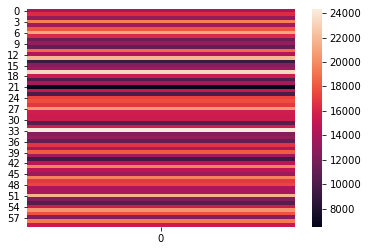

In [29]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [30]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [31]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1092, 0.3102, 0.1590, 0.2244, 0.2203, 0.2235, 0.1158, 0.2418, 0.0548,
        0.2233, 0.0514, 0.0799, 0.1109, 0.2903, 0.2281, 0.3313, 0.2916, 0.0392,
        0.0631, 0.1157, 0.1028, 0.2585, 0.0370, 0.0495, 0.0345, 0.1025, 0.4735,
        0.3372, 0.2318, 0.3076], device='cuda:0', grad_fn=<SliceBackward>)

In [32]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [33]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0473, 0.0384, 0.0520, 0.0631, 0.0463, 0.0494, 0.0489, 0.0506, 0.0409,
        0.0569, 0.0389, 0.0513, 0.0500, 0.0375, 0.0457, 0.0416, 0.0484, 0.0369,
        0.0451, 0.0478, 0.0505, 0.0509, 0.0311, 0.0371, 0.0308, 0.0505, 0.0220,
        0.0297, 0.0537, 0.0394], device='cuda:0', grad_fn=<SliceBackward>)

In [34]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.0001).cpu()

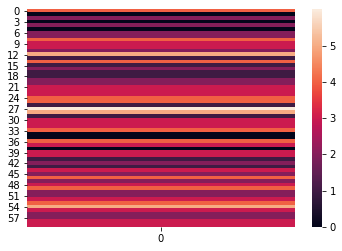

In [35]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [36]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3*z_size]

tensor([[44, 46, 27, 33, 36, 14, 59, 49, 53, 54, 24,  0, 12, 10,  4],
        [48, 10, 20, 46, 25, 14, 13, 12, 50, 22, 21, 28, 54, 32, 52],
        [12, 16, 36, 31, 37, 24, 48, 17, 59, 14, 33,  6, 55, 52,  9],
        [49, 41, 42, 43, 44,  0, 47, 12, 23, 56, 54, 28, 53, 58, 57],
        [40,  9, 54, 20, 46, 59, 28, 53, 21, 58,  8,  7,  2, 30, 27],
        [10, 22, 40, 25, 39, 49, 27, 28, 42, 58, 30,  8, 56, 57, 11],
        [36, 28, 19, 18, 23,  0, 47, 24, 27, 21,  8,  6, 37, 53, 54],
        [33,  9, 44, 15, 14, 40, 51, 39, 45,  7, 30, 32, 27, 37, 19],
        [25, 39, 27, 11, 52, 33, 55, 22, 24, 31,  4, 23,  2, 49, 51],
        [ 0, 46, 31, 32, 36, 25, 45, 48, 50, 55, 26, 29, 12,  8, 16]])

In [37]:
print(subset_indices[:, :D].sum())

print(subset_indices[:, D:2*D].sum())

tensor(72.9997)
tensor(77.0003)


In [38]:
torch.sum(w.argsort(descending= True)[:, :3*z_size] < 30)

tensor(72, device='cuda:0')

What happens if you run it on all the data? And not truncate the loss to the first D features?

In [39]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [40]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    test(test_data, vae_gumbel_truncated, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.028778
Train Epoch: 1 [1280/4000 (32%)]	Loss: 40.915230
Train Epoch: 1 [2560/4000 (64%)]	Loss: 39.910862
Train Epoch: 1 [3840/4000 (96%)]	Loss: 39.394970
====> Epoch: 1 Average loss: 40.4695
====> Test set loss: 39.0649
Train Epoch: 2 [0/4000 (0%)]	Loss: 39.088829
Train Epoch: 2 [1280/4000 (32%)]	Loss: 38.240669
Train Epoch: 2 [2560/4000 (64%)]	Loss: 37.056469
Train Epoch: 2 [3840/4000 (96%)]	Loss: 35.996536
====> Epoch: 2 Average loss: 37.6893
====> Test set loss: 35.8604
Train Epoch: 3 [0/4000 (0%)]	Loss: 35.930138
Train Epoch: 3 [1280/4000 (32%)]	Loss: 34.903442
Train Epoch: 3 [2560/4000 (64%)]	Loss: 34.834145
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.325855
====> Epoch: 3 Average loss: 34.9034
====> Test set loss: 34.1504
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.267342
Train Epoch: 4 [1280/4000 (32%)]	Loss: 34.246933
Train Epoch: 4 [2560/4000 (64%)]	Loss: 33.465240
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.505730
====> Epoch: 4 Average loss: 33.94

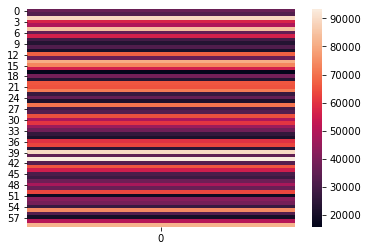

In [41]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [42]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [43]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1117, 0.3124, 0.1546, 0.2224, 0.2263, 0.2244, 0.1178, 0.2419, 0.0613,
        0.2224, 0.0488, 0.0724, 0.1090, 0.2857, 0.2340, 0.3341, 0.2930, 0.0407,
        0.0566, 0.1165, 0.1001, 0.2556, 0.0359, 0.0624, 0.0372, 0.1026, 0.4772,
        0.3331, 0.2251, 0.3030], device='cuda:0', grad_fn=<SliceBackward>)

In [44]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [45]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0505, 0.0445, 0.0496, 0.0526, 0.0504, 0.0454, 0.0481, 0.0426, 0.0387,
        0.0542, 0.0390, 0.0442, 0.0484, 0.0392, 0.0436, 0.0365, 0.0444, 0.0337,
        0.0407, 0.0490, 0.0481, 0.0379, 0.0336, 0.0435, 0.0325, 0.0502, 0.0217,
        0.0353, 0.0468, 0.0361], device='cuda:0', grad_fn=<SliceBackward>)

In [46]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.0001).cpu()

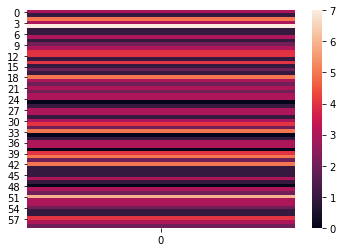

In [47]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [48]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3*z_size]

tensor([[35, 18, 59, 44, 40, 31, 30,  1, 21,  0, 10,  9,  4,  3, 11],
        [12, 31, 39, 23, 41, 43, 46, 47, 14, 33, 51, 52, 54, 57,  4],
        [10,  9, 23, 24, 42, 26, 51, 27, 53, 19, 33,  7, 40, 39,  2],
        [50, 51, 18, 42, 14, 40, 12, 11, 20, 27, 56, 36, 37, 22, 53],
        [17, 51, 18, 42, 15, 14, 27, 11, 21, 40, 57,  4, 31, 33, 30],
        [57, 50, 37, 28, 40, 54, 55, 32, 58,  3,  2,  6,  5,  7,  4],
        [33, 51, 19, 18,  0, 41, 14, 11, 23, 28,  4, 45, 58, 57, 30],
        [22, 28, 46, 16, 49, 12, 52, 36, 10, 33, 21,  2,  8, 31, 39],
        [12, 29, 53, 51, 49, 46, 42, 32, 24, 13,  0,  2,  7,  3,  4],
        [16, 19, 18, 59, 24, 49, 42, 52, 20, 58,  4,  2, 39, 36, 37]])

In [49]:
print(subset_indices[:, :D].sum())

print(subset_indices[:, D:2*D].sum())

tensor(75.9792)
tensor(74.0208)


In [50]:
torch.sum(w.argsort(descending= True)[:, :3*z_size] < 30)

tensor(80, device='cuda:0')

# How does a normal VAE do?

Trying to reconstruct first 30 features only

In [51]:
vanilla_vae = VAE(2*D, 100, 20)

vanilla_vae.to(device)
vanilla_vae_optimizer = torch.optim.Adam(vanilla_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [52]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vanilla_vae, 
                                         vanilla_vae_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    test(test_data, vanilla_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 21.213346
Train Epoch: 1 [1280/4000 (32%)]	Loss: 20.276854
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.344076
Train Epoch: 1 [3840/4000 (96%)]	Loss: 18.498720
====> Epoch: 1 Average loss: 19.7915
====> Test set loss: 39.3484
Train Epoch: 2 [0/4000 (0%)]	Loss: 18.456263
Train Epoch: 2 [1280/4000 (32%)]	Loss: 17.164484
Train Epoch: 2 [2560/4000 (64%)]	Loss: 15.890133
Train Epoch: 2 [3840/4000 (96%)]	Loss: 14.501512
====> Epoch: 2 Average loss: 16.4995
====> Test set loss: 36.2507
Train Epoch: 3 [0/4000 (0%)]	Loss: 14.773250
Train Epoch: 3 [1280/4000 (32%)]	Loss: 13.784710
Train Epoch: 3 [2560/4000 (64%)]	Loss: 13.811372
Train Epoch: 3 [3840/4000 (96%)]	Loss: 13.806759
====> Epoch: 3 Average loss: 13.9482
====> Test set loss: 35.1174
Train Epoch: 4 [0/4000 (0%)]	Loss: 13.142475
Train Epoch: 4 [1280/4000 (32%)]	Loss: 13.138114
Train Epoch: 4 [2560/4000 (64%)]	Loss: 12.924956
Train Epoch: 4 [3840/4000 (96%)]	Loss: 12.976542
====> Epoch: 4 Average loss: 13.15

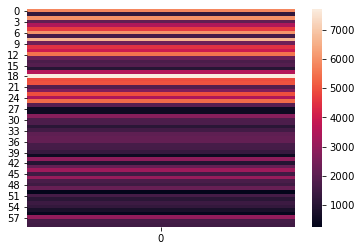

In [53]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [54]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [55]:
vanilla_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1093, 0.3065, 0.1559, 0.2122, 0.2189, 0.2161, 0.1051, 0.2298, 0.0646,
        0.2223, 0.0487, 0.0725, 0.1107, 0.2994, 0.2200, 0.3288, 0.2781, 0.0436,
        0.0481, 0.1081, 0.0969, 0.2486, 0.0358, 0.0561, 0.0365, 0.0938, 0.4796,
        0.3421, 0.2245, 0.3166], device='cuda:0', grad_fn=<SliceBackward>)

In [56]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [57]:
vanilla_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0733, 0.0475, 0.0694, 0.0722, 0.0665, 0.0721, 0.0719, 0.0769, 0.0611,
        0.0558, 0.0497, 0.0675, 0.0667, 0.0465, 0.0771, 0.0640, 0.0520, 0.0466,
        0.0468, 0.0687, 0.0650, 0.0743, 0.0426, 0.0530, 0.0434, 0.0701, 0.0274,
        0.0452, 0.0483, 0.0362], device='cuda:0', grad_fn=<SliceBackward>)

Looking at all dimensions

In [58]:
vanilla_vae = VAE(2*D, 100, 20)

vanilla_vae.to(device)
vanilla_vae_optimizer = torch.optim.Adam(vanilla_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [59]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vanilla_vae, 
                                         vanilla_vae_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    test(test_data, vanilla_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 41.973228
Train Epoch: 1 [1280/4000 (32%)]	Loss: 41.085449
Train Epoch: 1 [2560/4000 (64%)]	Loss: 40.187717
Train Epoch: 1 [3840/4000 (96%)]	Loss: 39.287830
====> Epoch: 1 Average loss: 40.5867
====> Test set loss: 39.2181
Train Epoch: 2 [0/4000 (0%)]	Loss: 39.292076
Train Epoch: 2 [1280/4000 (32%)]	Loss: 38.425259
Train Epoch: 2 [2560/4000 (64%)]	Loss: 37.164680
Train Epoch: 2 [3840/4000 (96%)]	Loss: 36.029900
====> Epoch: 2 Average loss: 37.7599
====> Test set loss: 36.0856
Train Epoch: 3 [0/4000 (0%)]	Loss: 36.332581
Train Epoch: 3 [1280/4000 (32%)]	Loss: 35.325539
Train Epoch: 3 [2560/4000 (64%)]	Loss: 34.929386
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.419472
====> Epoch: 3 Average loss: 35.1425
====> Test set loss: 34.4717
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.692886
Train Epoch: 4 [1280/4000 (32%)]	Loss: 34.117592
Train Epoch: 4 [2560/4000 (64%)]	Loss: 33.713638
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.654694
====> Epoch: 4 Average loss: 34.09

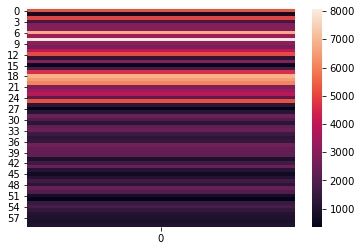

In [60]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [61]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [62]:
vanilla_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1091, 0.3042, 0.1509, 0.2060, 0.2198, 0.2101, 0.1092, 0.2246, 0.0496,
        0.2215, 0.0523, 0.0658, 0.1053, 0.2918, 0.2162, 0.3244, 0.2777, 0.0364,
        0.0611, 0.1036, 0.0885, 0.2473, 0.0406, 0.0635, 0.0381, 0.0854, 0.4745,
        0.3367, 0.2317, 0.3168], device='cuda:0', grad_fn=<SliceBackward>)

In [63]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [64]:
vanilla_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0736, 0.0476, 0.0689, 0.0689, 0.0612, 0.0657, 0.0744, 0.0722, 0.0609,
        0.0672, 0.0495, 0.0546, 0.0617, 0.0408, 0.0722, 0.0540, 0.0538, 0.0410,
        0.0621, 0.0677, 0.0719, 0.0687, 0.0469, 0.0589, 0.0429, 0.0712, 0.0297,
        0.0361, 0.0523, 0.0437], device='cuda:0', grad_fn=<SliceBackward>)

The gradients are a few epochs are good for selecting of features as the Gumbel trick. Maybe even better.
In fact, a Vanilla VAE is just as good.